In [2]:
import numpy as np
from scipy.special import binom
import matplotlib.pyplot as plt
from mpmath import whitw, besselk
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy.integrate import quad
import pandas as pd
import math
from scipy.interpolate import CubicSpline
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import fsolve, curve_fit
from timer import Timer
import os
from importlib import reload
import utilities
reload(utilities)
from utilities import EndOfInflation
import GEFv15
reload(GEFv15)
from GEFv15 import GEF

In [3]:
a = np.array([1, 2])
b = np.array([3, 4])
A = np.array([a, b])
print(A[1, 0])

3


In [2]:
Q = lambda x, xi, l: np.exp(l*np.pi*xi/2) * complex(whitw(-1j*xi*l, 1/2, -4j*abs(xi)*x))
P = lambda x, xi, l: np.exp(l*np.pi*xi/2) * (complex(whitw(-1j*xi*l, 1/2, -4j*abs(xi)*x))*1j*(1-l/2*np.sign(xi))
                                             + complex(whitw(1-1j*xi*l, 1/2, -4j*abs(xi)*x))/(2*abs(xi)*x))

In [3]:
Ef = lambda x, xi, l: abs(P(x, xi, l))**2
Bf = lambda x, xi, l: abs(Q(x, xi, l))**2
Gf = lambda x, xi, l: (P(x, xi, l)*Q(x, xi, l).conjugate()).real

In [18]:
iE = lambda x, xi, l: x**3*Ef(x, xi, l)

def iEapprx(xs, xi, l, order=4):
    ys = xs-1
    _, ts = Eapprx(xs, xi, l, order)
    
    pol = np.array([binom(order, i)*(ys)**i for i in range(order)])
    res = 0.
    for i in range(order):
        for j in range(order-i):
            res += ts[j]*pol[i]
    
    return res

def IEapprx(xs, xi, l, order=4):
    ys = xs-1
    _, ts = Eapprx(xs, xi, l, order)
    
    pol = np.array([binom(order, i)*(ys)**i for i in range(order)])
    res = 0.
    for i in range(order):
        for j in range(order-i):
            res += -ts[j]*pol[i]*ys/(i+j+1)
    
    return res

def Eapprx(xs, xi, l, order=4):
    
    ys = xs-1
    kappa = l*np.sign(xi)
    E = Ef(1, xi, l)
    G = Gf(1, xi, l)
    B = Bf(1, xi, l)
    t1 = E
    t2 = (1-kappa)/abs(xi)*G*ys
    t3 = ((-1 + kappa)*E + 2*(-1 + kappa)*abs(xi)*G
          + (-1+kappa)**2*B)/(2*abs(xi)**2)*ys**2/2
    t4 = (E*2*abs(xi)*(1-kappa) + 4*G*(abs(xi)**2 -1)*(1-kappa) 
          + 5*B*abs(xi)*(-1+kappa))/(2*abs(xi)**3)*ys**3/6
    
    ts = np.array([t1, t2, t3, t4])
    res = 0
    for i in range(order):
        res += ts[i]
    
    return res, ts

In [166]:
def Eapprx2(xs, xi, l):
    x = -0.325/xi + 0.97
    #print(x)
    y = (x - xs)
    E = Ef(x, xi, l)
    G = Gf(x, xi, l)
    B = Bf(x, xi, l)
    t0 = E*x**3
    kappa = l*np.sign(xi)
    xi = abs(xi)
    Eprime = (1-kappa)/(x*xi)*G
    E2prime = (-1 + kappa)*(x*E + 2*xi*G
          + (-x+kappa)*B)/(2*x**2*xi**2)
    t1 = 0#3*x**2*E + x**3*Eprime
    t2 = (6*x*E + 6*x**2*Eprime + x**3*E2prime)/2
    return t0 + t1*y + t2*y**2
    

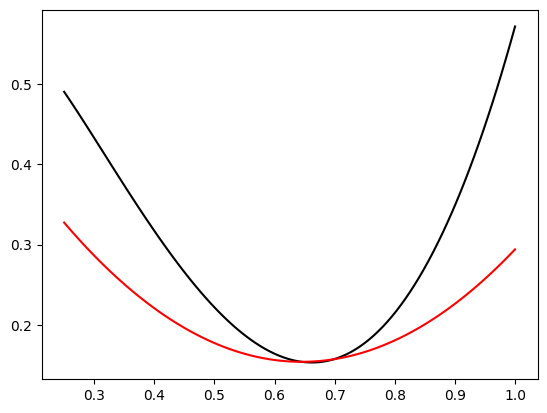

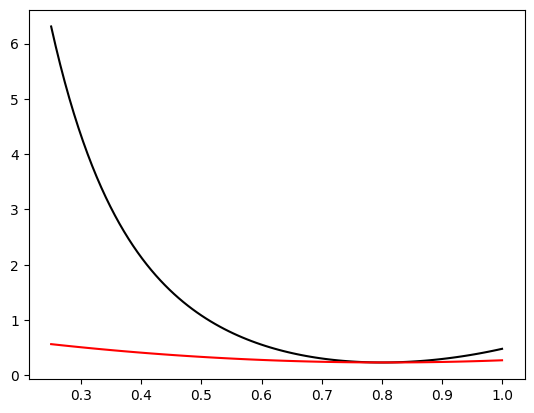

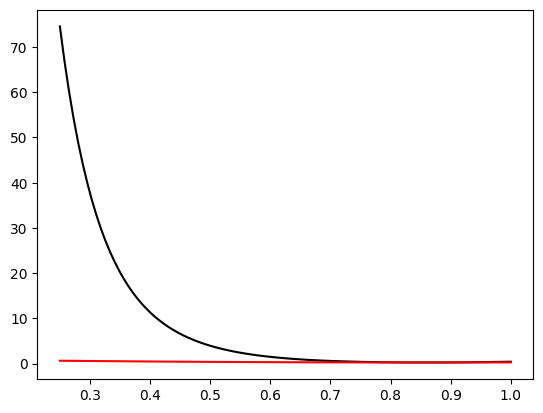

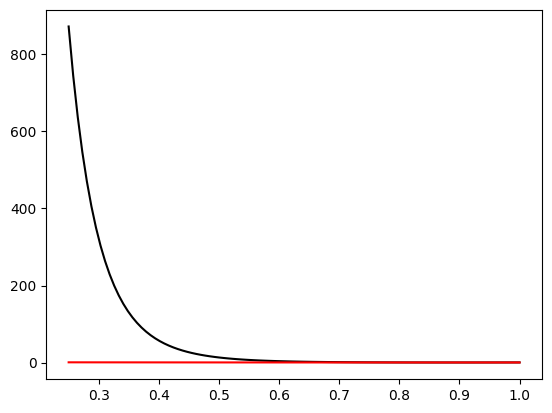

In [167]:
xis = np.arange(1, 5, 1)
xs = np.linspace(0.25, 1, 100)
for xi in xis:
    E1 = []
    E21 = []
    for x in xs:
        E1.append(iE(x, xi, 1))
        E21.append(Eapprx2(x, xi, 1))
    E1 = np.array(E1)
    E21 = np.array(E21)
    plt.plot(xs, E1, "k")
    plt.plot(xs, E21, "r")
    #plt.yscale("log")
    plt.show()

In [129]:
xis = np.arange(1, 5, 0.1)
xs = np.linspace(0.25, 1, 1000)
m = []
for xi in xis:
    iEs = 1e100
    xmin = 0.
    for x in xs:
        etmp = iE(x, xi, 1.)
        if etmp < iEs:
            iEs = etmp
            xmin = x
    m.append(xmin)
plt.plot(xis, m, "r.")

KeyboardInterrupt: 

In [116]:
f = lambda x, a, b: -a/x+b

In [123]:
val = curve_fit(f, xis, np.array(m), p0=[3.8/4-0.7, 3.8/4])[0]

In [124]:
print(val)

[0.32581465 0.97002392]


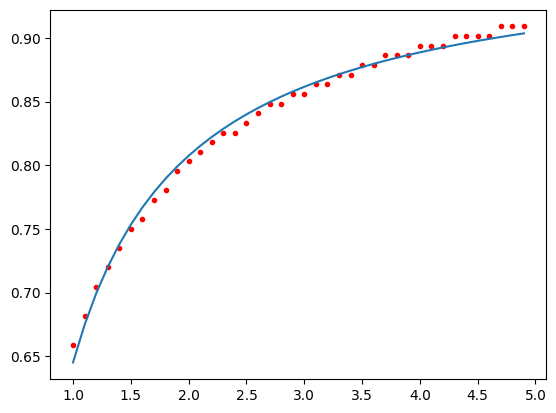

In [128]:
plt.plot(xis, m, "r.")
plt.plot(xis, f(xis, 0.325, 0.97))
#plt.xscale("log")

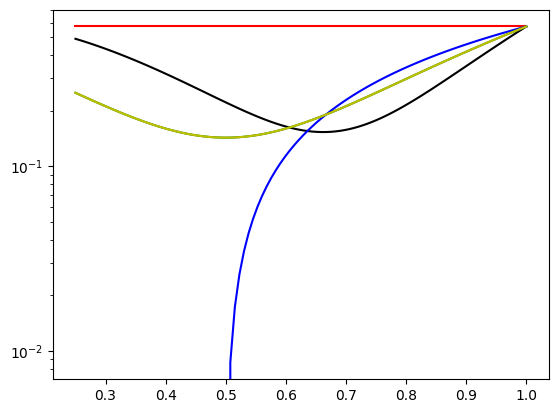

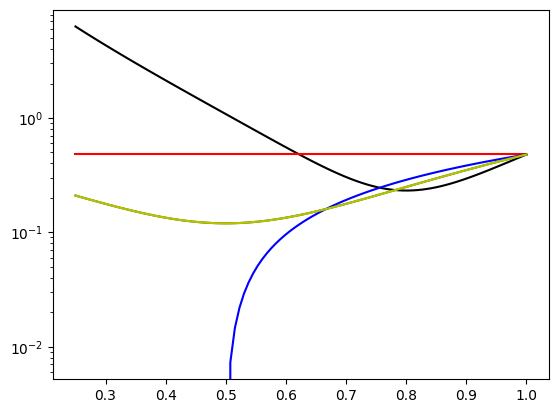

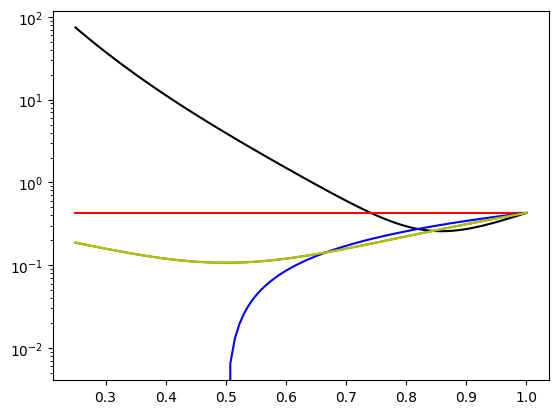

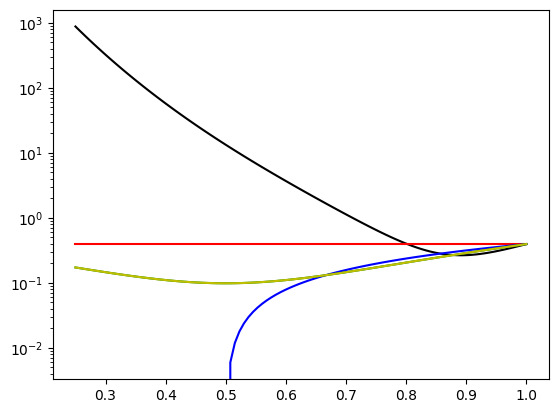

In [19]:
xis = np.arange(1, 5, 1)
xs = np.linspace(0.25, 1, 100)
for xi in xis:
    E1 = []
    E21 = []
    E22 = []
    E23 = []
    E24 = []
    for x in xs:
        E1.append(iE(x, xi, 1))
        E21.append(iEapprx(x, xi, 1, order=1))
        E22.append(iEapprx(x, xi, 1, order=2))
        E23.append(iEapprx(x, xi, 1, order=3))
        E24.append(iEapprx(x, xi, 1, order=4))
    E1 = np.array(E1)
    E21 = np.array(E21)
    E22 = np.array(E22)
    E23 = np.array(E23)
    E24 = np.array(E24)
    plt.plot(xs, E1, "k")
    plt.plot(xs, E21, "r")
    plt.plot(xs, E22, "b")
    plt.plot(xs, E23, "g")
    plt.plot(xs, E23, "y")
    plt.yscale("log")
    plt.show()

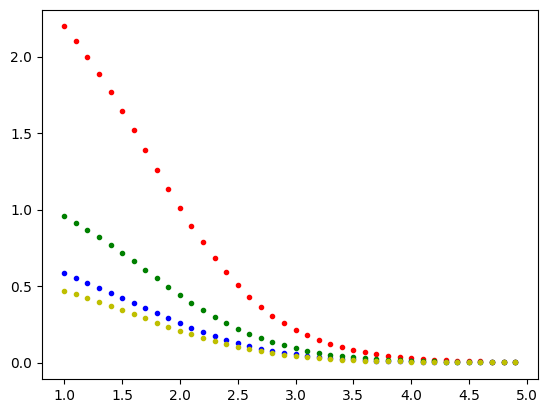

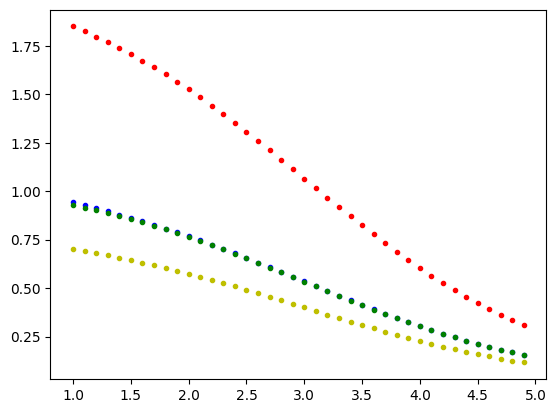

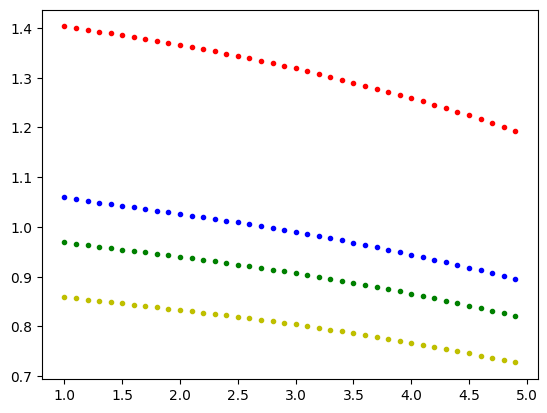

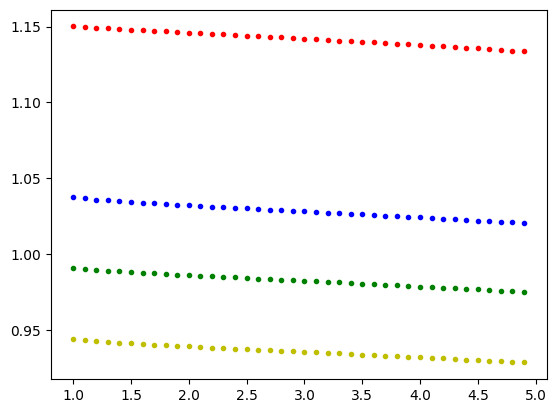

In [21]:
xis = np.arange(1, 5, 0.1)
xss = np.array([0.25, 0.5, 0.75, 0.9])

for xs in xss:
    q1 = []
    q21 = []
    q22 = []
    q23 = []
    q24 = []
    for xi in xis:
        q1.append(quad(iE, xs, 1., args=(xi,1,))[0] + quad(iE, xs, 1., args=(xi,-1,))[0])
        q21.append(IEapprx(xs, xi, 1, order=1) + IEapprx(xs, xi, -1, order=1))
        q22.append(IEapprx(xs, xi, 1, order=2) + IEapprx(xs, xi, -1, order=2))
        q23.append(IEapprx(xs, xi, 1, order=3) + IEapprx(xs, xi, -1, order=3))
        q24.append(IEapprx(xs, xi, 1, order=4) + IEapprx(xs, xi, -1, order=4))
    q1 = np.array(q1)
    q21 = np.array(q21)
    q22 = np.array(q22)
    q23 = np.array(q23)
    q24 = np.array(q24)
    plt.plot(xis, q21/q1, "r.")
    plt.plot(xis, q22/q1, "b.")
    plt.plot(xis, q23/q1, "g.")
    plt.plot(xis, q24/q1, "y.")
    plt.show()
                       
        

In [22]:
alpha = 0.
Mpl = 1.
beta = 25.
M = 6e-6*Mpl
phi0 = 15.55*Mpl
dphidt0 = -np.sqrt(2/3)*M*Mpl
ini = {"phi":phi0, "dphi":dphidt0, "delta":1.0, "rhoChi":0.0}
SE = 0.0
ntr = 55
#G = GEF(alpha, beta, Mpl, ini, M, ntr, SE, AltDamp=0, approx=True)
#F = GEF(alpha, beta, Mpl, ini, M, ntr, SE, AltDamp=1, approx=True)
H = GEF(alpha, beta, Mpl, ini, M, ntr, SE, AltDamp=2, approx=True)
omega=H.H0

file = "Out/GEF_Beta25.0_SE-1.0_KDep_0it.dat"
H.LoadData(file)
H.Unitless()
NR = H.vals["N"]
xiR = H.vals["xi"]
khR = H.vals["kh"]
kSR = H.vals["kS"]

xsR = kSR/khR


Already Unitless


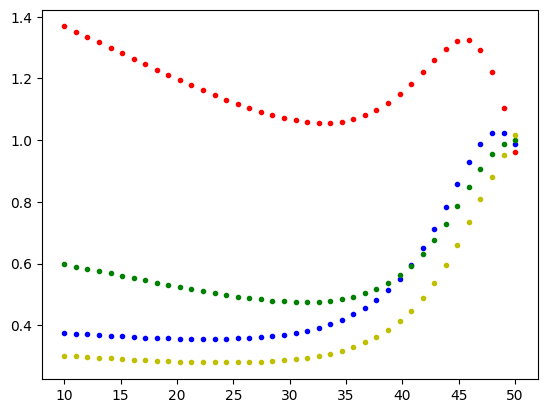

In [23]:
N = np.linspace(10, 50, 40)
xs = CubicSpline(NR, xsR)(N)
xi = CubicSpline(NR, xiR)(N)
q1 = []
q21 = []
q22 = []
q23 = []
q24 = []
for k in range(N.size):
    q1.append(quad(iE, xs[k], 1., args=(xi[k],1,))[0] + quad(iE, xs[k], 1., args=(xi[k],-1,))[0])
    q21.append(IEapprx(xs[k], xi[k], 1, order=1) + IEapprx(xs[k], xi[k], -1, order=1))
    q22.append(IEapprx(xs[k], xi[k], 1, order=2) + IEapprx(xs[k], xi[k], -1, order=2))
    q23.append(IEapprx(xs[k], xi[k], 1, order=3) + IEapprx(xs[k], xi[k], -1, order=3))
    q24.append(IEapprx(xs[k], xi[k], 1, order=4) + IEapprx(xs[k], xi[k], -1, order=4))
q1 = np.array(q1)
q21 = np.array(q21)
q22 = np.array(q22)
q23 = np.array(q23)
q24 = np.array(q24)
plt.plot(N, q21/q1, "r.")
plt.plot(N, q22/q1, "b.")
plt.plot(N, q23/q1, "g.")
plt.plot(N, q24/q1, "y.")
plt.show()

In [86]:
Q = lambda x, xi: np.exp(np.pi*xi/2) * complex(whitw(-1j*xi, 1/2, -4j*abs(xi)*x))
Qapprox = lambda x, xi: x**(1/4) * np.exp( xi*(np.pi-4.*x**(1/2) ))
Qapprox2 = lambda x, xi: 2*(x*xi/np.pi)**(1/2) * np.exp( xi*np.pi) * besselk(1, 4*xi*x**(1/2) )

In [87]:
xi = 3
x = np.linspace(0.25, 1.)
Qarr = abs(np.array([complex(Q(y, xi)) for y in x]))
Qarr2 = Qapprox(x, xi)
Qarr3 = Qapprox(x, xi)

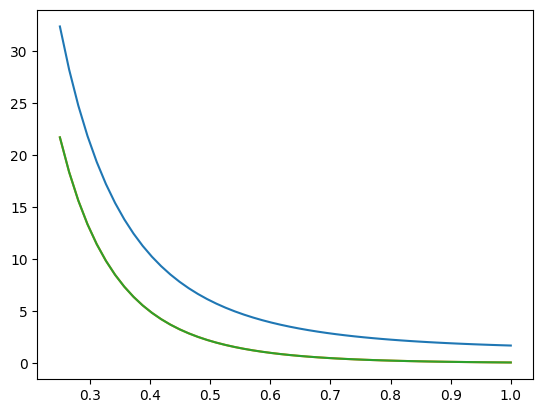

In [88]:
plt.plot(x, Qarr)
plt.plot(x, Qarr2)
plt.plot(x, Qarr3)

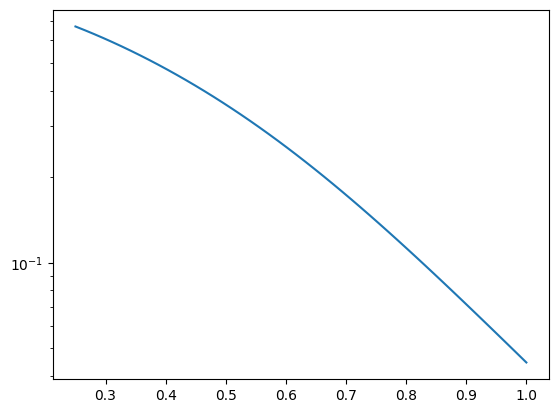

In [89]:
plt.plot(x, Qarr2/Qarr)
plt.yscale("log")
#plt.plot(x, Qarr2/Qarr3)

In [100]:
int1 = lambda x, xi: x**4*abs(Q(x, xi)**2)
int2 = lambda x, xi: x**4*Qapprox(x, xi)**2

In [101]:
quad1 = lambda xi: quad(int1, 0.25, 1., args=(xi,))
quad2 = lambda xi: quad(int2, 0.25, 1., args=(xi,))

In [105]:
xis = np.arange(1, 5, 0.1)

In [106]:
q1 = []
q2 = []
for xi in xis:
    q1.append(quad1(xi)[0])
    q2.append(quad2(xi)[0])

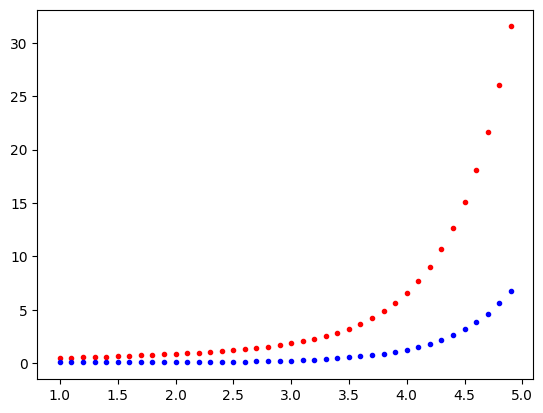

In [107]:
plt.plot(xis, np.array(q1), "r.")
plt.plot(xis, np.array(q2), "b.")